In [15]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('./data/oasis_cleaned.csv')
data = data[['ID','CDR']]
data.head()

,ID,CDR
0,OAS1_0001_MR1,0.0
1,OAS1_0002_MR1,0.0
2,OAS1_0003_MR1,0.5
3,OAS1_0004_MR1,0.5
4,OAS1_0005_MR1,0.5


In [7]:
root_dir = './assets/OASIS-1/processed/'


# Data Preprocessing for MRI Scans
In the following cells, we will preprocess the MRI scan data by:
1. Loading the .gif images from the OASIS-1 dataset
2. Converting them to grayscale and resizing to 128x128 pixels
3. Normalizing pixel values to [0,1] range
4. Preparing labels from CDR scores
5. Converting data into format suitable for CNN training


In [8]:
# Create lists to store images and labels
images = []
labels = []


# Walk through all 12 disks
for disk_num in tqdm(range(1, 13), desc='Processing disks'):
    disk_path = os.path.join(root_dir, f'disc{disk_num}')
    for folder in tqdm(os.listdir(disk_path), desc=f'Processing folders in disk {disk_num}', leave=False):
    # for folder in list(os.listdir(disk_path))[:10]:
        folder_path = os.path.join(disk_path, folder)
        if os.path.isdir(folder_path):
            # Get CDR score for this subject
            subject_id = folder  # Append _MR1 to match ID format in data
            try:
                cdr_score = data[data['ID'] == subject_id]['CDR'].values[0]
                
                # Load all .gif images from this folder
                for img_file in os.listdir(folder_path):
                    if img_file.endswith('.gif'):
                        img_path = os.path.join(folder_path, img_file)
                        # Open and convert to grayscale numpy array
                        img = Image.open(img_path).convert('L')
                        img = img.resize((128, 128))  # Resize for consistency
                        img_array = np.array(img) / 255.0  # Normalize to [0,1]
                        images.append(img_array)
                        labels.append(cdr_score)
            except Exception as e:
                print(f"Error processing {subject_id}: {str(e)}")
                raise

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Reshape images for CNN input
X = X.reshape(-1, 128, 128, 1)
# Looking at unique CDR values to determine number of classes
unique_cdrs = np.unique(y)
num_classes = len(unique_cdrs)
print(f"Unique CDR values: {unique_cdrs}")
print(f"Number of classes: {num_classes}")


Processing disks: 100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Unique CDR values: [0.  0.5 1.  2. ]
Number of classes: 4


In [9]:
# Reshape y to have shape (n_samples, 5)
y = np.zeros((len(y), 5))
for i, label in enumerate(labels):
    y[i, int(label)] = 1

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print key dataset statistics
print(f"Total number of images: {len(images)}")
print(f"Total number of labels: {len(labels)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Image dimensions: {X_train.shape[1:]}")
# Print shape of y after reshaping
print(f"Shape of y after reshaping: {y.shape[1]} classes")


Total number of images: 4304
Total number of labels: 4304
Training samples: 3443
Test samples: 861
Image dimensions: (128, 128, 1)
Shape of y after reshaping: 5 classes


# Building, Training and Testing the CNN Model

In the next few cells, we will:
1. Build a CNN model using TensorFlow/Keras with convolutional layers, max pooling, dense layers and dropout for regularization
2. Compile the model with appropriate loss function and optimizer
3. Train the model on our training data while monitoring validation performance
4. Evaluate the final model performance on the test set


In [30]:
# Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Get model output for sample input
sample_output = model.predict(X_train[:1])
target_values = y_train[0]
output_values = sample_output[0]

print(f"Target values: {target_values}")
print(f"Model output values: {output_values}")



# Train model
history = model.fit(X_train, y_train,
                   epochs=20, 
                   validation_data=(X_test, y_test),
                   batch_size=32)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.3f}')
# Create directory if it doesn't exist
save_dir = './trained_models'
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_save_path = os.path.join(save_dir, 'cnn_model_1.h5')
model.save(model_save_path)
print(f'\nModel saved to: {model_save_path}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Target values: [0. 1. 0. 0. 0.]
Model output values: [0.5008905  0.49515426 0.50155646 0.49823058 0.502363  ]
Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 68s 600ms/step - accuracy: 0.8822 - loss: 0.4792 - val_accuracy: 0.9326 - val_loss: 0.2839
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 65s 598ms/step - accuracy: 0.9289 - loss: 0.3078 - val_accuracy: 0.9326 - val_loss: 0.2637
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 64s 589ms/step - accuracy: 0.9246 - loss: 0.2874 - val_accuracy: 0.9326 - val_loss: 0.2321
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 64s 589ms/step - accuracy: 0.9260 - loss: 0.2402 - val_accuracy: 0.9326 - val_loss: 0.2468
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 64s 595ms/step - accuracy: 0.9280 - loss: 0.2235 - val_accuracy: 0.9326 - val_loss: 0.2080
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 67s 619ms/step - accuracy: 0.9251 - loss: 0.2001 - val_accuracy: 0.9326 - val_loss: 0.2120
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 67s 616ms/step - accuracy


Test accuracy: 0.961

Model saved to: ./trained_models/cnn_model_1.h5


In [28]:
# Build a deeper CNN model with different architecture
model2 = tf.keras.Sequential([
    # First conv block with batch normalization
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Second conv block
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Third conv block
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    
    
    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

# Compile with different optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train model with more epochs and early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history2 = model2.fit(X_train, y_train,
                     epochs=20,
                     validation_data=(X_test, y_test),
                     batch_size=32,
                     callbacks=[early_stopping])

# Evaluate model
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
print(f'\nTest accuracy of second model: {test_acc2:.3f}')
# Save the trained model
model_save_path = './trained_models/cnn_model_2.h5'
model2.save(model_save_path)
print(f'Model saved to {model_save_path}')


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8246 - loss: 3.6209 - val_accuracy: 0.9326 - val_loss: 0.4223
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8971 - loss: 0.4874 - val_accuracy: 0.9326 - val_loss: 0.2905
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9219 - loss: 0.3805 - val_accuracy: 0.9326 - val_loss: 0.2634
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9267 - loss: 0.3448 - val_accuracy: 0.9326 - val_loss: 0.3288
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9350 - loss: 0.3020 - val_accuracy: 0.9326 - val_loss: 0.2392
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9303 - loss: 0.2761 - val_accuracy: 0.9326 - val_loss: 0.2535
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 92s 848ms/step - accuracy: 0.9263 - loss: 0.2878 - val_accuracy: 0.9326 - val_loss: 0.2722
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 74s 686ms/step - accuracy: 0.9298 - loss: 0.2857 - val_


Test accuracy of second model: 0.933
Model saved to ./trained_models/cnn_model_2.h5


In [29]:
# Build a third CNN model with a simpler architecture
model3 = tf.keras.Sequential([
    # First conv block
    tf.keras.layers.Conv2D(32, 5, padding='same', input_shape=(128, 128, 1)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.MaxPooling2D(),
    
    # Third conv block
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

# Compile model
model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history3 = model3.fit(X_train, y_train,
                     epochs=20,
                     validation_data=(X_test, y_test),
                     batch_size=32)

# Evaluate model
test_loss3, test_acc3 = model3.evaluate(X_test, y_test)
print(f'\nTest accuracy of third model: {test_acc3:.3f}')

# Save the trained model
model_save_path = './trained_models/cnn_model_3.h5'
model3.save(model_save_path)
print(f'Model saved to {model_save_path}')



Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1208s 11s/step - accuracy: 0.9017 - loss: 0.4635 - val_accuracy: 0.9326 - val_loss: 0.2713
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9310 - loss: 0.3093 - val_accuracy: 0.9326 - val_loss: 0.2621
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 786ms/step - accuracy: 0.9175 - loss: 0.3254 - val_accuracy: 0.9326 - val_loss: 0.2378
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 789ms/step - accuracy: 0.9333 - loss: 0.2363 - val_accuracy: 0.9326 - val_loss: 0.2453
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 788ms/step - accuracy: 0.9317 - loss: 0.2182 - val_accuracy: 0.9326 - val_loss: 0.2239
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 87s 805ms/step - accuracy: 0.9334 - loss: 0.1889 - val_accuracy: 0.9326 - val_loss: 0.2043
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 147s 858ms/step - accuracy: 0.9307 - loss: 0.1768 - val_accuracy: 0.9350 - val_loss: 0.1964
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 91s 838ms/step - accuracy: 0.9440 - loss: 0.


Test accuracy of third model: 0.973
Model saved to ./trained_models/cnn_model_3.h5


# Model Comparison
In the following cells, we will compare the performance of the three CNN models we built. We'll analyze their training and validation metrics, including accuracy and loss curves over epochs, to understand how each architecture performed and determine which model is most effective for our MRI classification task.


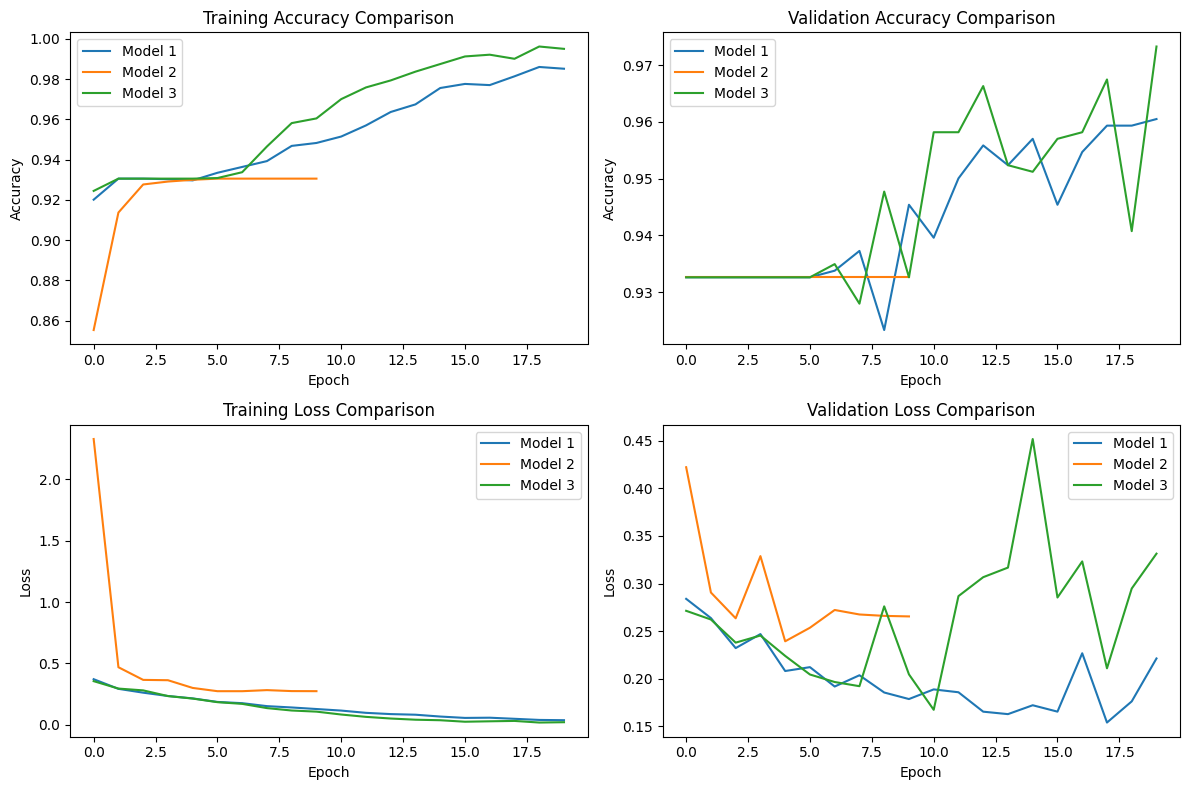

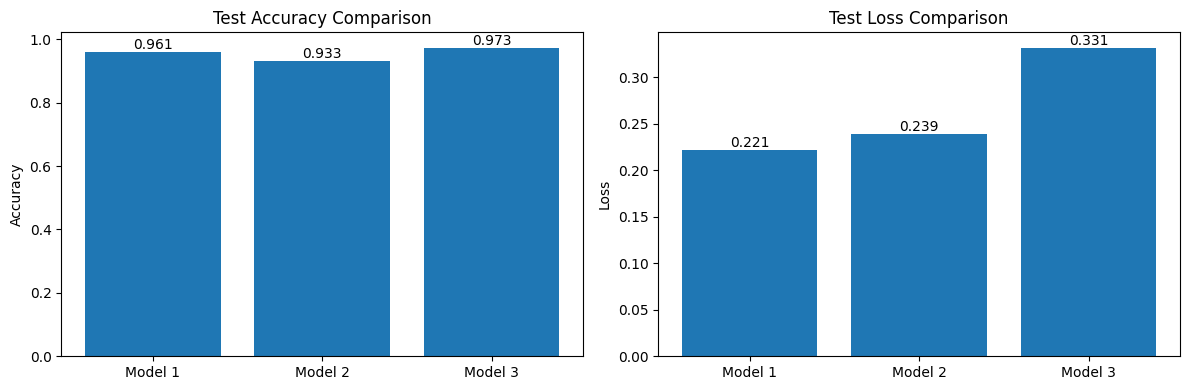


Best performing model: Model 3 with validation accuracy of 0.922


In [32]:
# Create figures for accuracy and loss comparisons/home/rohitb/projects/ml/Project/mri_data_analysis/data/oasis_cleaned.csv
plt.figure(figsize=(12, 8))

# Plot training accuracy for all models
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1')
plt.plot(history2.history['accuracy'], label='Model 2')
plt.plot(history3.history['accuracy'], label='Model 3')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy for all models
plt.subplot(2, 2, 2)
plt.plot(history.history['val_accuracy'], label='Model 1')
plt.plot(history2.history['val_accuracy'], label='Model 2')
plt.plot(history3.history['val_accuracy'], label='Model 3')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss for all models
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Model 1')
plt.plot(history2.history['loss'], label='Model 2')
plt.plot(history3.history['loss'], label='Model 3')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss for all models
plt.subplot(2, 2, 4)
plt.plot(history.history['val_loss'], label='Model 1')
plt.plot(history2.history['val_loss'], label='Model 2')
plt.plot(history3.history['val_loss'], label='Model 3')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Create bar plots for test metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Test Accuracy bar plot
models = ['Model 1', 'Model 2', 'Model 3']
accuracies = [test_acc, test_acc2, test_acc3]
ax1.bar(models, accuracies)
ax1.set_title('Test Accuracy Comparison')
ax1.set_ylabel('Accuracy')
for i, v in enumerate(accuracies):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Test Loss bar plot  
losses = [test_loss, test_loss2, test_loss3]
ax2.bar(models, losses)
ax2.set_title('Test Loss Comparison')
ax2.set_ylabel('Loss')
for i, v in enumerate(losses):
    ax2.text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Identify best performing model based on validation metrics
best_val_acc1 = max(history.history['val_accuracy'])
best_val_acc2 = max(history2.history['val_accuracy'])
best_val_acc3 = max(history3.history['val_accuracy'])

best_val_loss1 = min(history.history['val_loss'])
best_val_loss2 = min(history2.history['val_loss'])
best_val_loss3 = min(history3.history['val_loss'])

# Normalize metrics to 0-1 range for fair comparison
acc_max = max(best_val_acc1, best_val_acc2, best_val_acc3)
acc_min = min(best_val_acc1, best_val_acc2, best_val_acc3)
loss_max = max(best_val_loss1, best_val_loss2, best_val_loss3)
loss_min = min(best_val_loss1, best_val_loss2, best_val_loss3)

norm_acc1 = (best_val_acc1 - acc_min) / (acc_max - acc_min) if acc_max != acc_min else 1
norm_acc2 = (best_val_acc2 - acc_min) / (acc_max - acc_min) if acc_max != acc_min else 1
norm_acc3 = (best_val_acc3 - acc_min) / (acc_max - acc_min) if acc_max != acc_min else 1

norm_loss1 = 1 - ((best_val_loss1 - loss_min) / (loss_max - loss_min)) if loss_max != loss_min else 1
norm_loss2 = 1 - ((best_val_loss2 - loss_min) / (loss_max - loss_min)) if loss_max != loss_min else 1
norm_loss3 = 1 - ((best_val_loss3 - loss_min) / (loss_max - loss_min)) if loss_max != loss_min else 1

# Calculate combined score (average of normalized accuracy and inverted normalized loss)
scores = [
    (1, (norm_acc1 + norm_loss1) / 2),
    (2, (norm_acc2 + norm_loss2) / 2),
    (3, (norm_acc3 + norm_loss3) / 2)
]

best_model = max(scores, key=lambda x: x[1])

print(f"\nBest performing model: Model {best_model[0]} with validation accuracy of {best_model[1]:.3f}")
